In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [81]:
url = 'https://raw.githubusercontent.com/anyawild/DS3000_Final_Project_Team2/refs/heads/main/test_euro_c_df_clean.csv'
euro_c_df_clean = pd.read_csv(url)
euro_c_df_clean.head()

,Unnamed: 0,country_id,latitude,longitude,bright_ti4,bright_ti5,scan,track,confidence,acq_date,acq_time,frp,daynight
0,0,AUT,47.34311,9.62378,328.5,290.2,0.53,0.42,n,2020-03-01,1230,4.4,D
1,1,AUT,47.54527,9.78854,331.0,287.0,0.54,0.42,n,2020-03-01,1230,5.0,D
2,2,AUT,47.54559,9.78841,329.3,286.5,0.54,0.42,n,2020-03-01,1230,3.7,D
3,3,AUT,48.27758,14.34202,331.8,276.3,0.59,0.53,n,2020-03-01,1230,3.8,D
4,4,AUT,48.27502,14.33618,300.4,279.2,0.58,0.70,n,2020-06-01,218,1.9,N


In [82]:
euro_c_df_clean['frp'].describe()

count    3781.000000
mean        4.112327
std         7.565538
min         0.200000
25%         1.230000
50%         2.500000
75%         4.700000
max       159.480000
Name: frp, dtype: float64

In [83]:
# observations at max bright_ti4 (normal saturation, no foldover)
normal_saturation_df = euro_c_df_clean[euro_c_df_clean['bright_ti4'] == euro_c_df_clean['bright_ti4'].max()]
normal_saturation_df['frp'].describe()

count     35.000000
mean      16.102286
std       25.941722
min        3.740000
25%        7.710000
50%       10.220000
75%       14.550000
max      159.480000
Name: frp, dtype: float64

### Checking for bright_ti4 Foldover

In [84]:
euro_c_df_clean['bright_ti4'].describe()

count    3781.000000
mean      320.378328
std        17.895367
min       207.930000
25%       302.830000
50%       322.200000
75%       335.320000
max       367.000000
Name: bright_ti4, dtype: float64

In [85]:
euro_c_df_clean['bright_ti5'].describe()

count    3781.00000
mean      287.09831
std        10.66879
min       247.67000
25%       280.16000
50%       285.20000
75%       292.90000
max       354.27000
Name: bright_ti5, dtype: float64

When foldover occurs, bright_ti4 will have a significantly lower value than bright_ti5 near the low end of its detection threshold (~208K).

In [86]:
# foldover occurs when bright_ti4 < bright_ti5 and bright_ti4 is near its lower threshold (~208)
foldover_df = euro_c_df_clean[euro_c_df_clean['bright_ti4'] - euro_c_df_clean['bright_ti5'] < 0]
foldover_df = foldover_df[foldover_df['bright_ti4'] < 220]
foldover_df

,Unnamed: 0,country_id,latitude,longitude,bright_ti4,bright_ti5,scan,track,confidence,acq_date,acq_time,frp,daynight
1980,1980,FRA,44.05268,-0.01614,207.93,308.93,0.39,0.36,l,2022-03-01,1246,61.87,D


# Logistic Regression for Classification

We perform logistic regression to classify fires as standard or high-intensity based on latitude, longitude, scan, track, and days since earliest data acquisition date.

In [87]:
# create binary intensity column (high = 1, standard = 0)
euro_c_df_clean['intensity_binary'] = np.where(
    (euro_c_df_clean['bright_ti4'] > 350) | 
    ((euro_c_df_clean['bright_ti4'] - euro_c_df_clean['bright_ti5'] < 0) & 
     (euro_c_df_clean['bright_ti4'] < 220)),
    1,  # high-intensity: bright_ti4 > 350, OR
        #                 bright_ti4 - bright_ti5 < 0 & bright_ti4 < 220 (foldover)
    0   # standard-intensity: all other observations
)

# create days column
# date -> days since earliest date
date = euro_c_df_clean['acq_date']
x_datetime = pd.to_datetime(date)
reference_date = pd.Timestamp(date.min())       # earliest date, '2020-03-01'
x_timedelta = x_datetime - reference_date
euro_c_df_clean['days'] = x_timedelta.dt.days

In [88]:
intensity_counts = euro_c_df_clean['intensity_binary'].value_counts()

print(f'# of Standard-Intensity Fires: {intensity_counts.get(0, 0)}')
print(f'# of High-Intensity Fires: {intensity_counts.get(1, 0)}')

# of Standard-Intensity Fires: 3655
# of High-Intensity Fires: 126


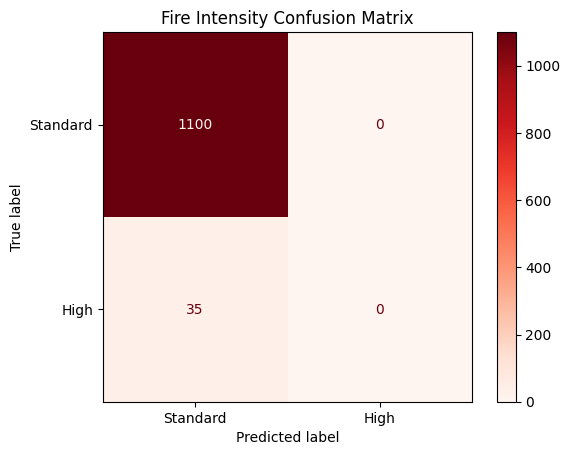

Accuracy: 0.969
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
AUC-ROC: 0.691


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [89]:
X = euro_c_df_clean[['latitude', 'longitude', 'scan', 'track', 'days']]     # feature variables
y = euro_c_df_clean['intensity_binary']                                     # classes: standard (0), high (1)

# split the dataset into training and test sets 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

# standardize feature variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

# train the model using standardized features
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# test the model
y_pred = log_reg.predict(X_test_scaled)

# assess model accuracy using confusion/classification matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Standard', 'High'])
disp.plot(cmap='Reds')
plt.title('Fire Intensity Confusion Matrix')
plt.show()

# analyzing model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:,1])

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print(f'AUC-ROC: {roc_auc:.3f}')

The model consistently predicts only standard-intensity for all test samples. This behavior is likely caused by a class imbalance in the dataset, where the majority class (standard-intensity fires, n=3655) dominates, causing the model to ignore the minority class (high-intensity fires, n=126). This imbalance biases the model toward standard-intensity fires, resulting in a lack of predictive power for high-intensity fires.

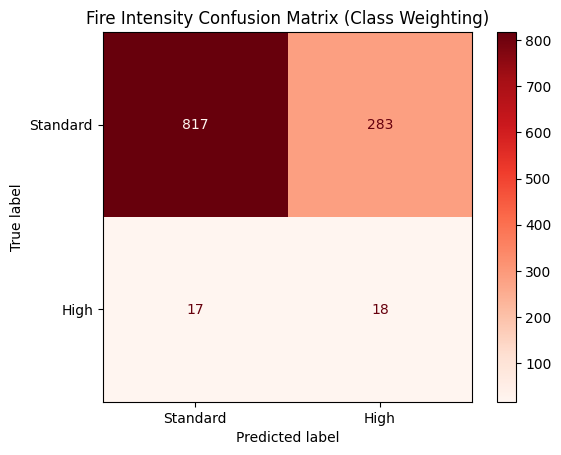

Accuracy: 0.736
Precision: 0.060
Recall: 0.514
F1-Score: 0.107
AUC-ROC: 0.689


In [90]:
X = euro_c_df_clean[['latitude', 'longitude', 'scan', 'track', 'days']]     # feature variables
y = euro_c_df_clean['intensity_binary']                                     # classes: standard (0), high (1)

# split the dataset into training and test sets 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

# standardize feature variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

# train the model using standardized features and balanaced class weights
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

# test the model
y_pred = log_reg.predict(X_test_scaled)

# assess model accuracy using confusion/classification matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Standard', 'High'])
disp.plot(cmap='Reds')
plt.title('Fire Intensity Confusion Matrix (Class Weighting)')
plt.show()

# analyzing model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:,1])

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print(f'AUC-ROC: {roc_auc:.3f}')

On the other hand, balancing class weights in the model leads to significant misclassification of standard-intensity fires as high-intensity.